# Studium Przypadku

Temat: **Binarna ocena utworu na podstawie preferencji użytkownika (system rekomendacji)**

Zbiór danych: [_Spotify Recommendation_](https://www.kaggle.com/datasets/bricevergnou/spotify-recommendation?fbclid=IwAR1yqJMFO9sxB9Mv_18c3L0dcctaOZ_YHZo0xqV2JPG6GmTT3V8kK_M5dhk) 

Autor: Marcin Krueger 145244

Data: 05.06.2023

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from xgboost import XGBClassifier, plot_tree

from imblearn.metrics import geometric_mean_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sklearn import tree

## Dane

Zbiór danych składa się z 13 zmiennych warunkowych oraz jednej binarnej zmiennej decyzyjnej (`liked`)

Zmienne warunkowe:
- acousticness [`0.0 - 1.0`] - reprezentuje pewność, że utwór jest akustyczny (bez wzmacniaczy)
- danceability [`0.0 - 1.0`] - opisuje, jak odpowiedni jest utwór do tańca w oparciu o kombinację elementów muzycznych, w tym tempo, stabilność rytmu, siłę uderzenia i ogólną regularność
- duration_ms [`ms`] - długość utworu w milisekundach
- energy [`0.0 - 1.0`] - reprezentuje percepcyjną miarę intensywności i aktywności. Zazwyczaj utwory energetyczne są szybkie, głośne i hałaśliwe. Na przykład death metal ma wysoką energię, podczas gdy preludium Bacha osiąga niskie wyniki na skali. Cechy percepcyjne przyczyniające się do tego atrybutu obejmują zakres dynamiki, postrzeganą głośność, barwę dźwięku, szybkość narastania i ogólną entropię.
- instrumentalness [`0.0 - 1.0`] - Przewiduje, czy utwór nie zawiera wokalu. Dźwięki "ooh" i "aah" są w tym kontekście traktowane jako instrumentalne. Utwory rapowe lub mówione są wyraźnie "wokalne". Im wartość instrumentalności jest bliższa 1.0, tym większe prawdopodobieństwo, że utwór nie zawiera wokalu. Wartości powyżej 0.5 mają reprezentować utwory instrumentalne, ale pewność jest wyższa, gdy wartość zbliża się do 1.0.
- key [`0.0 - 11.0`] - Klucz, w którym znajduje się ścieżka. Liczby całkowite mapują do tonacji przy użyciu standardowej notacji. Np. 0 = C, 1 = C♯/D♭, 2 = D itd.
- liveness [`0.0 - 1.0`] - Wykrywa obecność publiczności w nagraniu. Wyższe wartości liveness oznaczają zwiększone prawdopodobieństwo, że utwór został wykonany na żywo. Wartość powyżej 0,8 zapewnia duże prawdopodobieństwo, że utwór został wykonany na żywo. 
- loudness [`-60.0db - 0.0db`] - Ogólna głośność utworu w decybelach (dB). Wartości głośności są uśredniane dla całej ścieżki i są przydatne do porównywania względnej głośności ścieżek. Głośność to jakość dźwięku, która jest głównym psychologicznym korelatem siły fizycznej (amplitudy).
- mode [`0.0, 1.0`] - Tryb wskazuje modalność (dur lub moll) ścieżki, rodzaj skali, z której pochodzi jej treść melodyczna. Major jest reprezentowany przez 1, a minor przez 0.
- speechiness [`0.0 - 1.0`] - wykrywa obecność wypowiadanych słów w utworze. Im bardziej nagranie przypomina mowę (np. talk show, audiobook, poezja), tym wartość atrybutu jest bliższa 1,0. Wartości powyżej 0,66 opisują utwory, które prawdopodobnie składają się w całości z wypowiadanych słów. Wartości między 0,33 a 0,66 opisują utwory, które mogą zawierać zarówno muzykę, jak i mowę, w sekcjach lub warstwowo, w tym takie przypadki jak muzyka rap. Wartości poniżej 0,33 najprawdopodobniej reprezentują muzykę i inne utwory niepodobne do mowy.
- tempo [`1.0 - inf`] - Ogólne szacowane tempo utworu w uderzeniach na minutę (BPM). W terminologii muzycznej tempo jest prędkością lub tempem danego utworu i wynika bezpośrednio ze średniego czasu trwania taktu.
- time_signature [`C`] - Szacunkowa sygnatura czasowa utworu. Sygnatura czasowa (metrum) to konwencja notacyjna określająca liczbę uderzeń w każdym takcie (lub miarze).
- valence [`0.0 - 1.0`] - miara opisująca muzyczną pozytywność przekazywaną przez utwór. Utwory o wysokiej wartościowości brzmią bardziej pozytywnie (np. szczęśliwe, radosne, euforyczne), podczas gdy utwory o niskiej wartościowości brzmią bardziej negatywnie (np. smutne, przygnębione, gniewne).

In [2]:
data = pd.read_csv("./data/data.csv")

y = data["liked"]
X_data = data.drop(labels = "liked", axis=1)

data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.451,0.000734,0.1000,0.6280,95.968,304524,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.206,0.000000,0.0912,0.5190,151.329,247178,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.992,0.897000,0.1020,0.0382,75.296,286987,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.431,0.000001,0.1230,0.5820,89.860,208920,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.145,0.000000,0.0753,0.6470,155.117,179413,4,1


### Rozkład danych

In [3]:
X_data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,0.636656,0.638431,5.497436,-9.481631,0.538462,0.148957,0.319093,0.192337,0.148455,0.493632,121.086174,213408.933333,3.912821
std,0.216614,0.260096,3.415209,6.525086,0.499802,0.120414,0.320782,0.346226,0.105975,0.267695,28.084829,72152.392864,0.451332
min,0.130000,0.002400,0.000000,-42.261000,0.000000,0.027800,0.000003,0.000000,0.033100,0.035300,60.171000,77203.000000,1.000000
25%,0.462500,0.533500,2.000000,-9.962000,0.000000,0.056800,0.042200,0.000000,0.084000,0.269000,100.242000,178300.500000,4.000000
50%,0.705000,0.659000,6.000000,-7.766000,1.000000,0.096200,0.213000,0.000008,0.105000,0.525000,124.896000,204000.000000,4.000000
75%,0.799000,0.837500,8.000000,-5.829000,1.000000,0.230500,0.504000,0.097500,0.177000,0.717500,142.460500,242373.500000,4.000000
max,0.946000,0.996000,11.000000,-2.336000,1.000000,0.540000,0.995000,0.969000,0.633000,0.980000,180.036000,655213.000000,5.000000


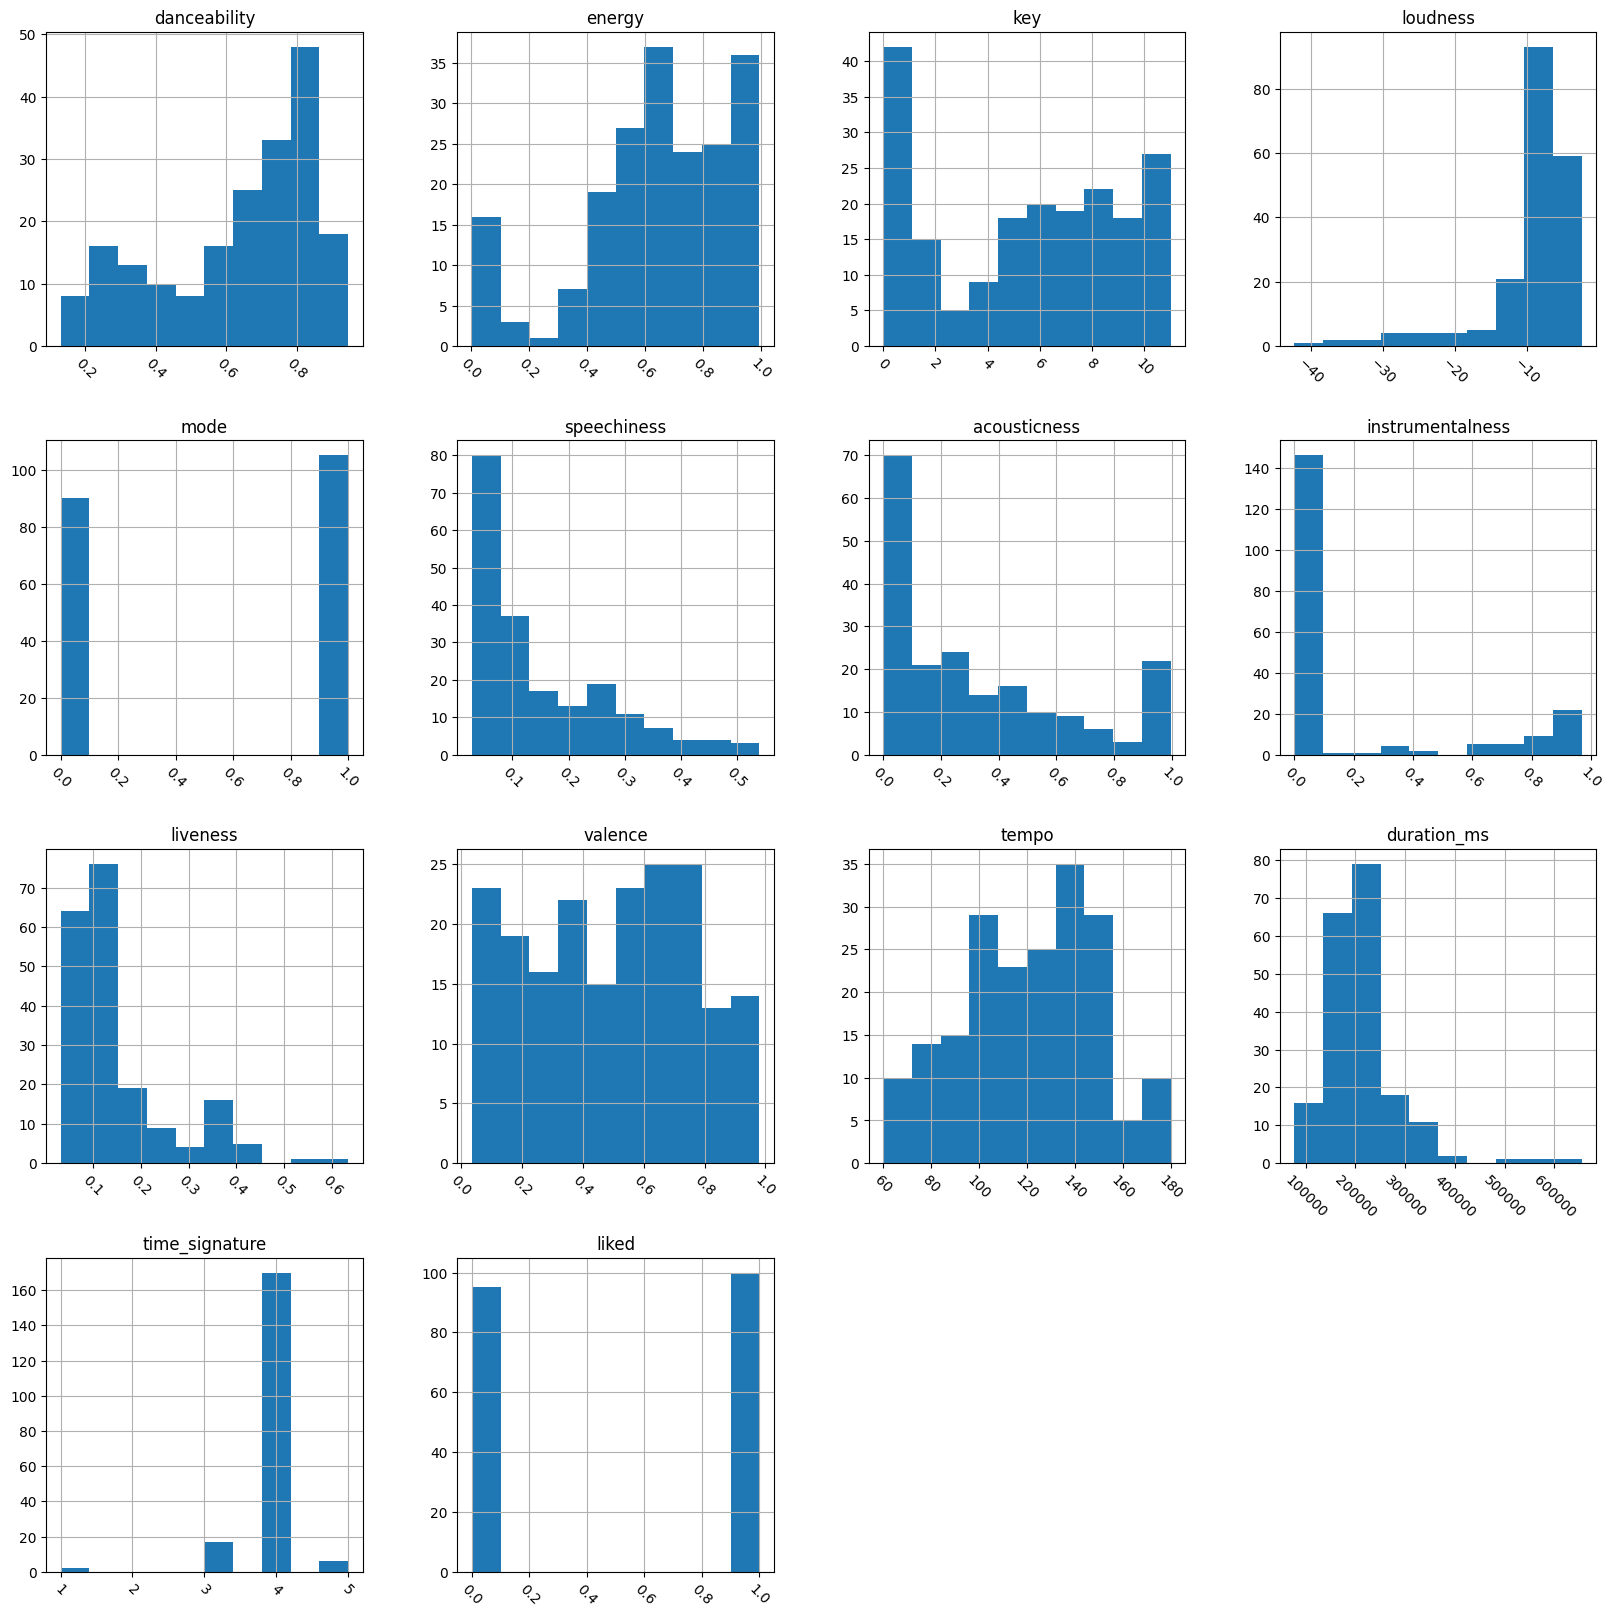

In [6]:
data.hist(figsize=(20, 20), xrot=-45)
plt.show()

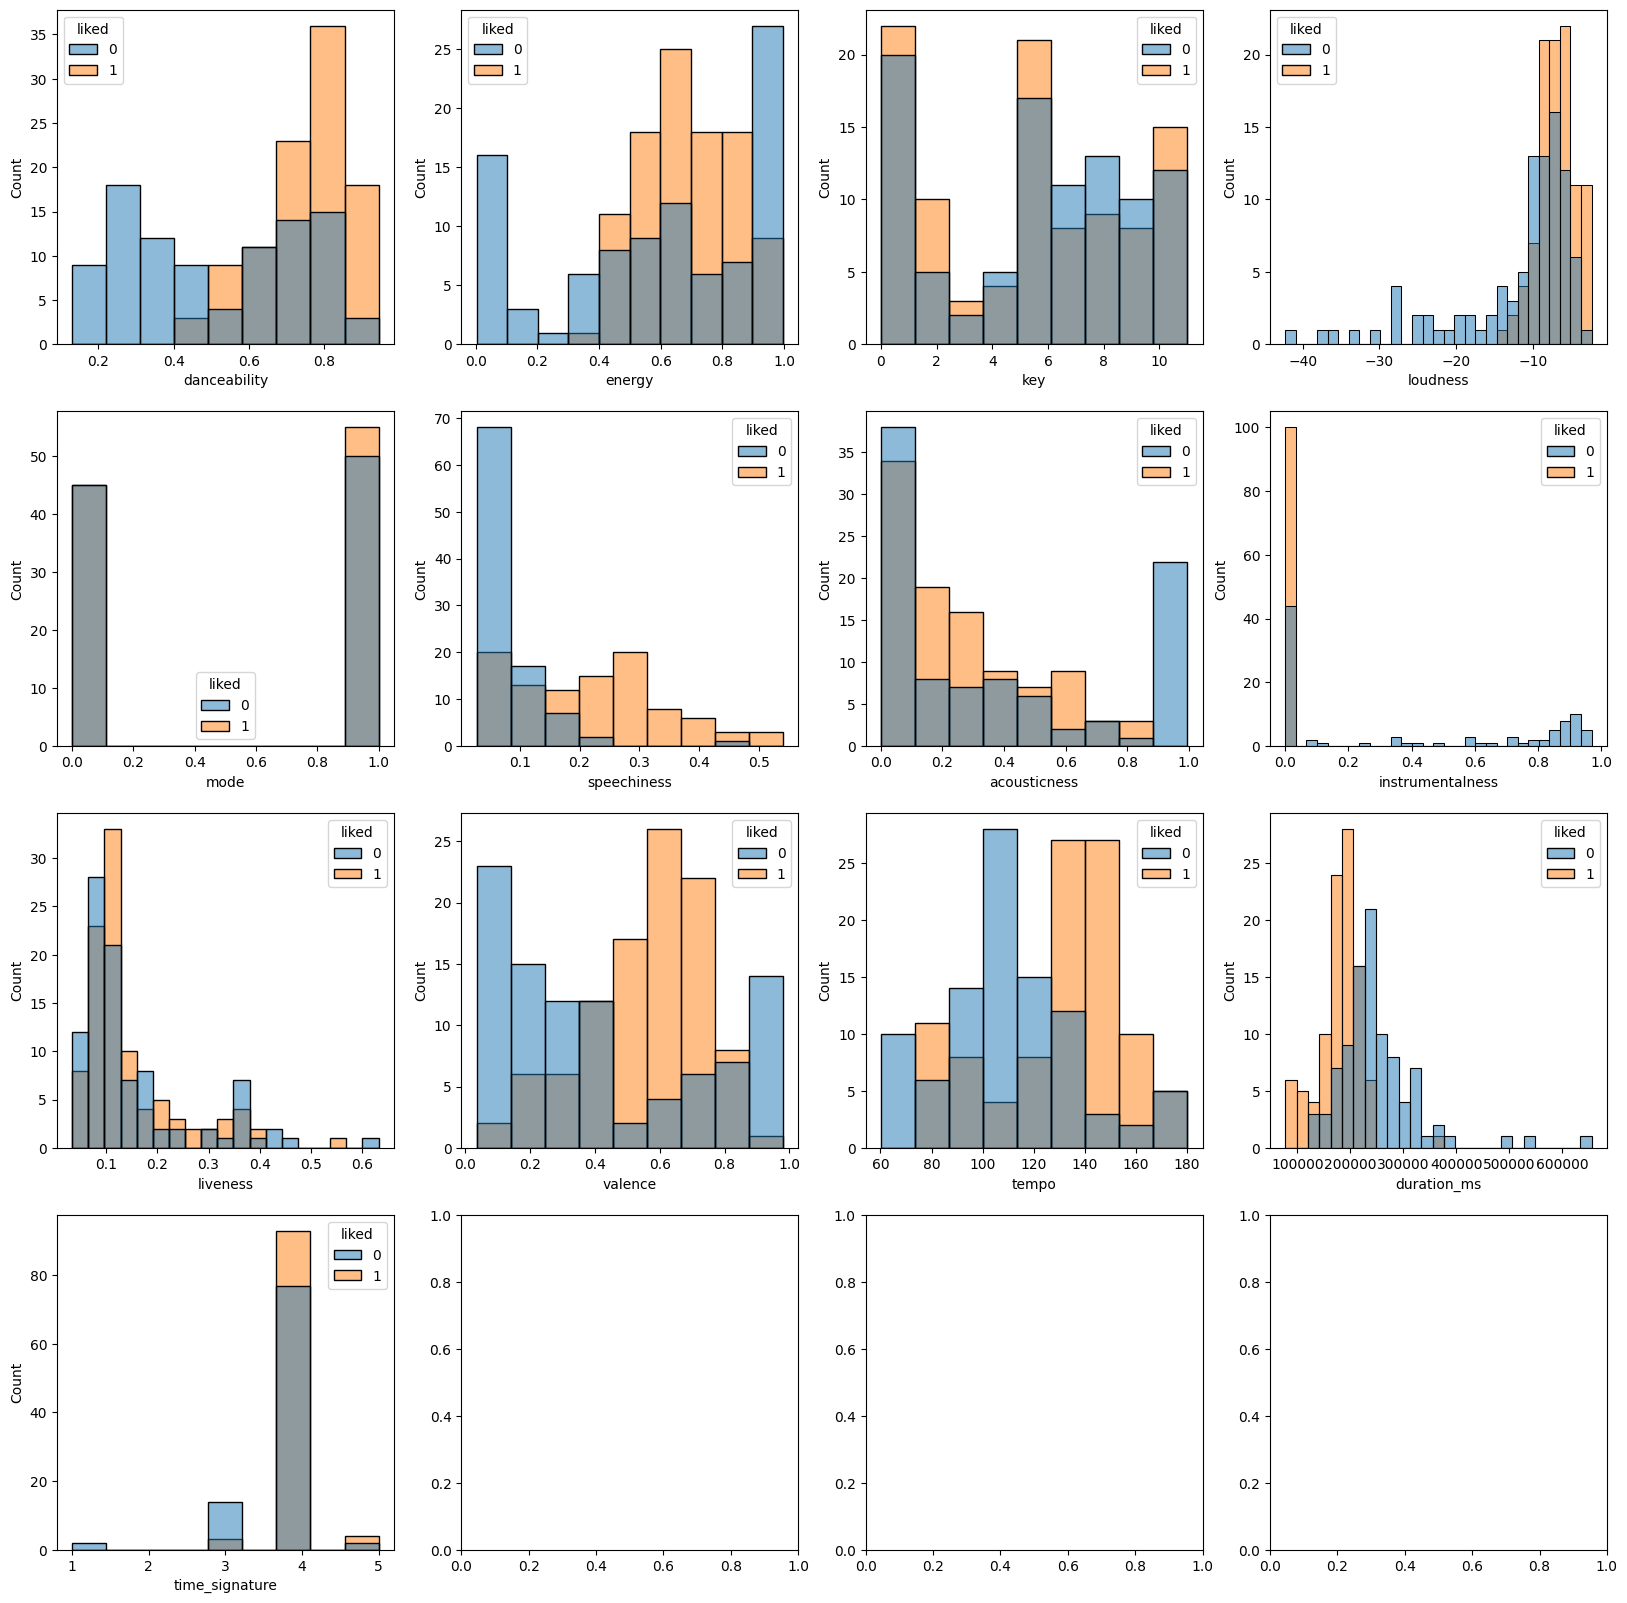

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for index, col in enumerate(X_data.columns):
    sns.histplot(data, x=col, hue="liked", ax=axes[index // 4][index % 4])

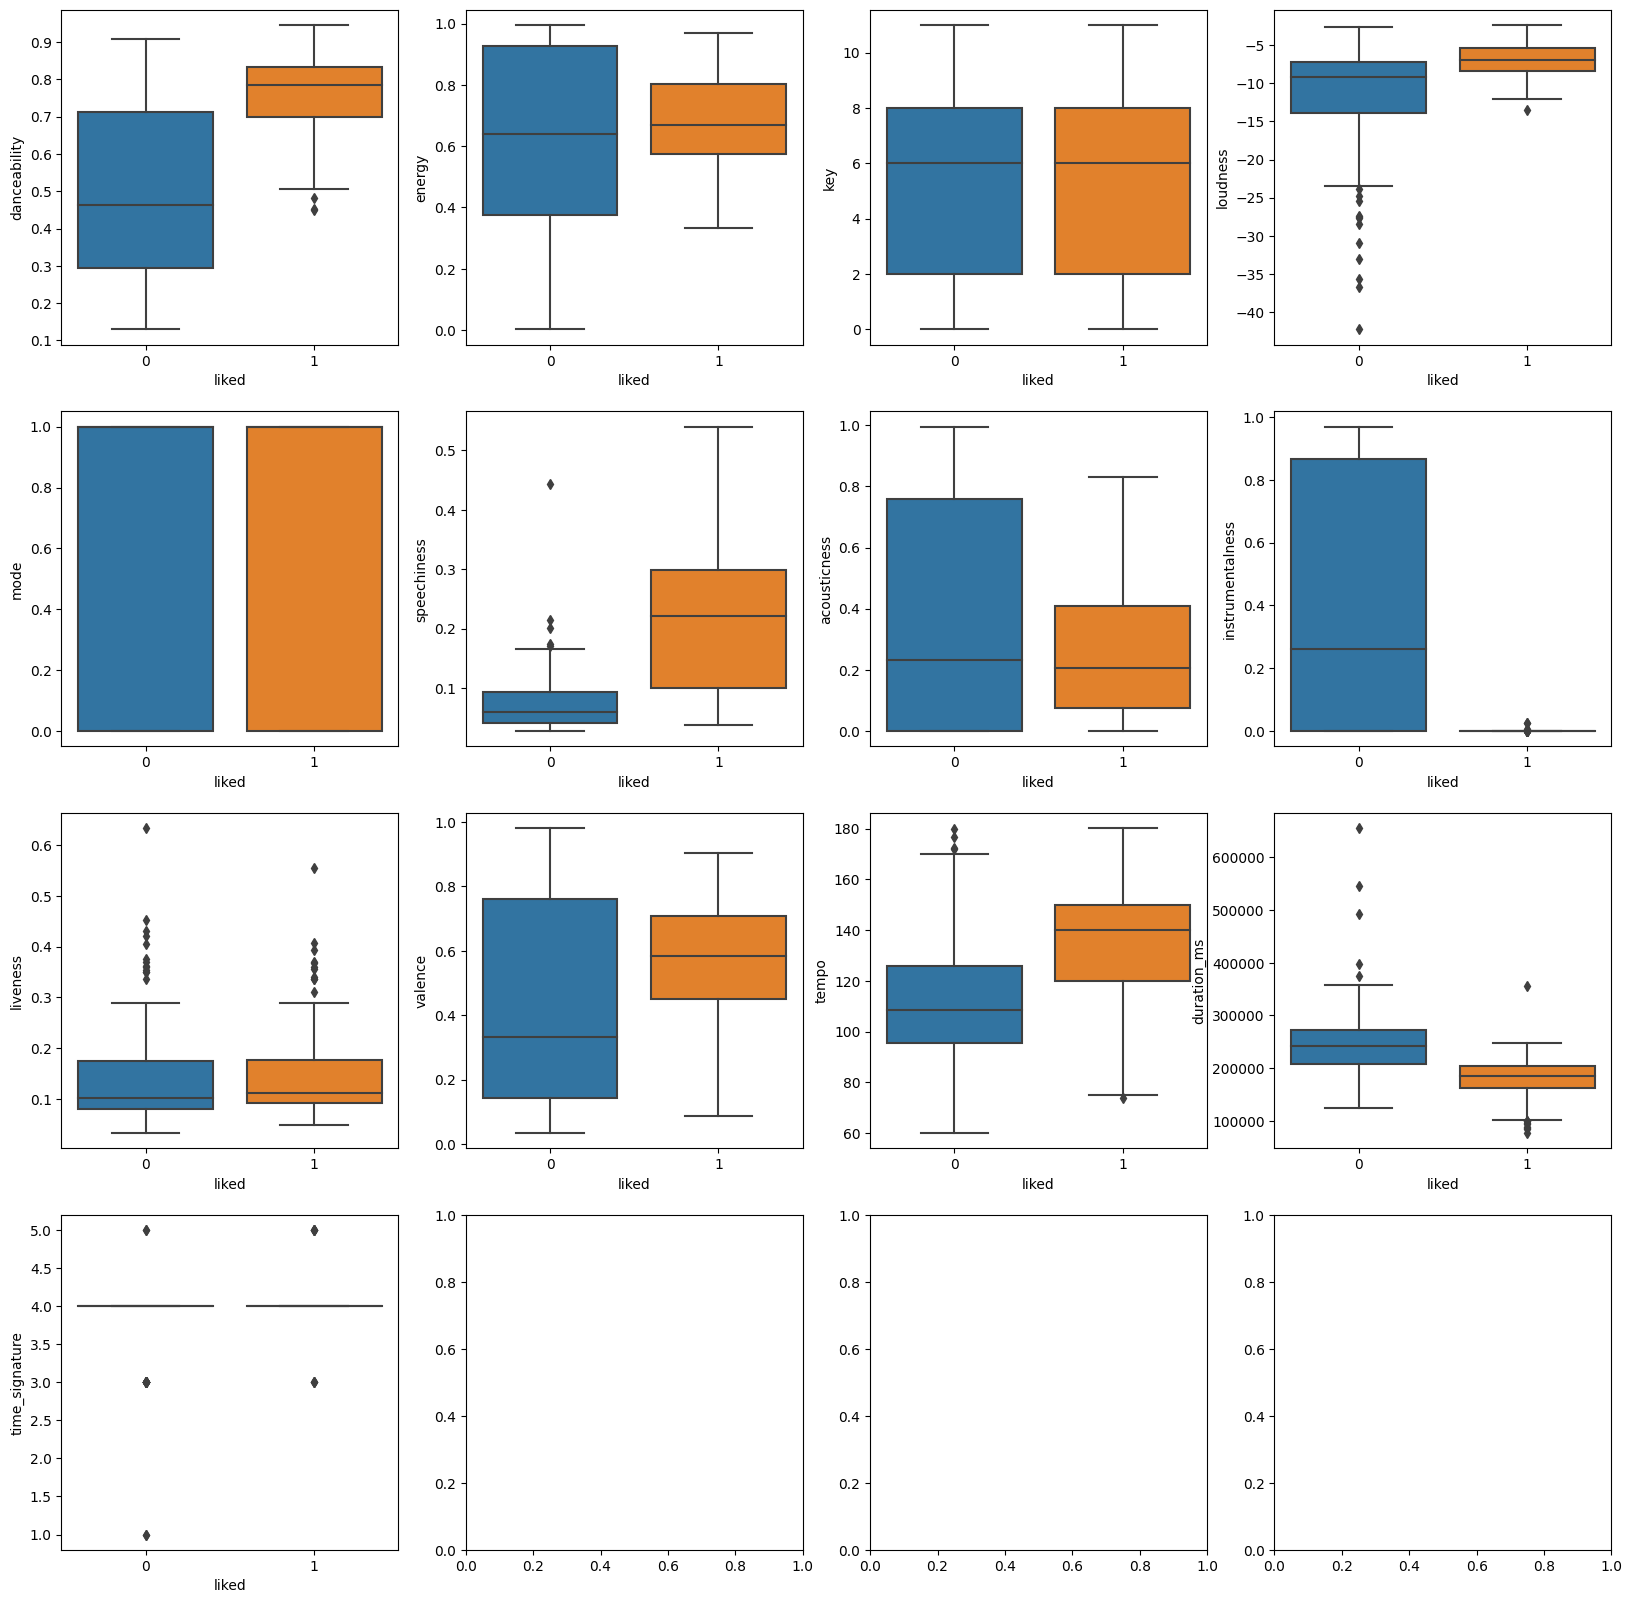

In [79]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for index, col in enumerate(X_data.columns):
    sns.boxplot(data, x='liked', y=col, ax=axes[index // 4][index % 4])

### Macierz korelacji

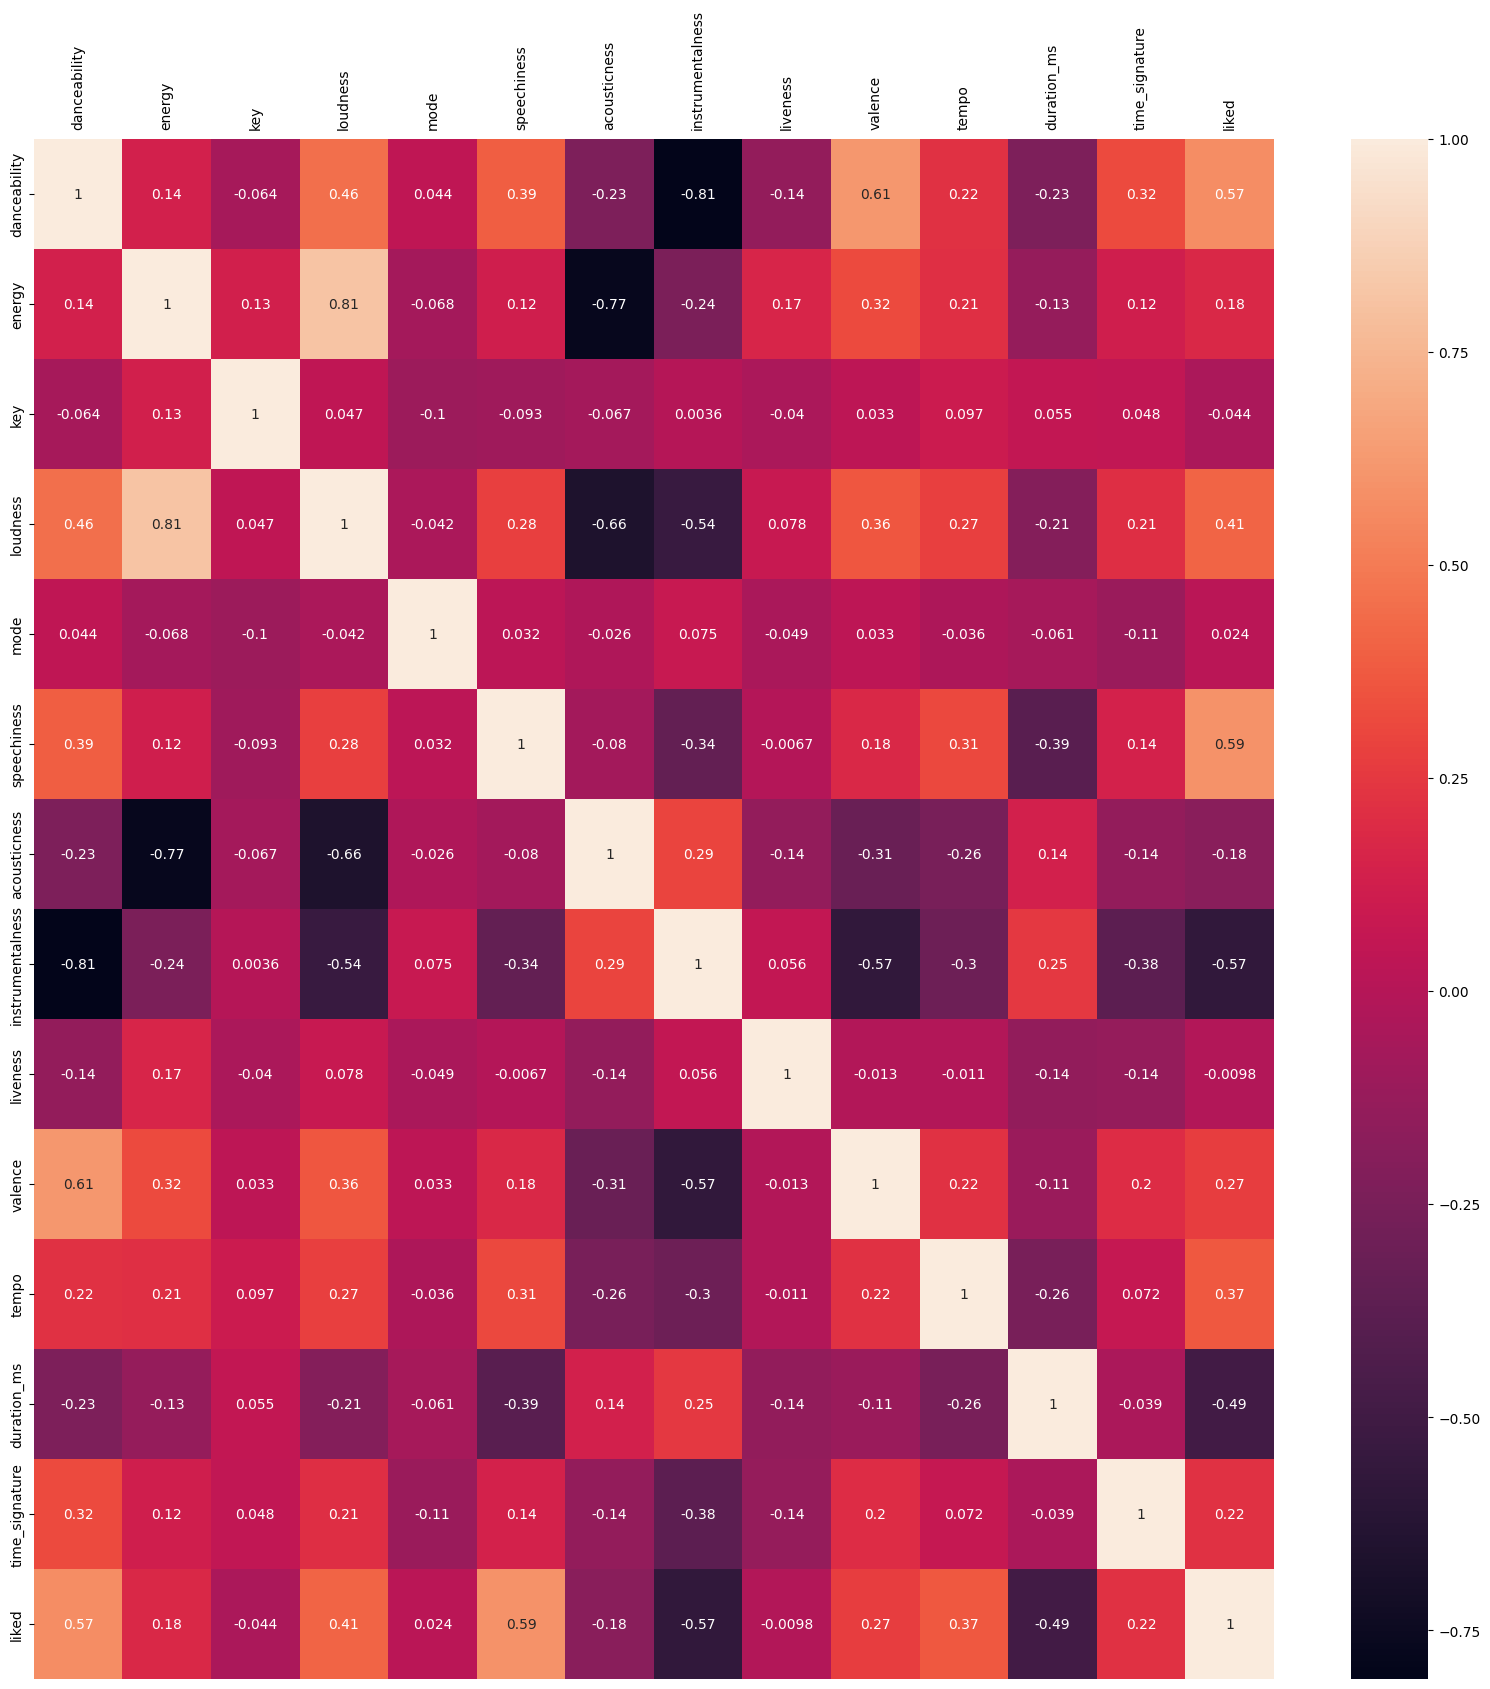

In [78]:
corr = data.corr()
plt.figure(figsize=(20,20))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
sns.heatmap(corr, annot=True)
plt.show()

## Opis wybranych przypadków

In [15]:
pd.DataFrame(data.iloc[9])

,9
danceability,0.853
energy,0.668
key,3.000
loudness,-6.995
mode,1.000
speechiness,0.447
acousticness,0.263
instrumentalness,0.000
liveness,0.104
valence,0.745


In [16]:
pd.DataFrame(data.iloc[10])

,10
danceability,0.297000
energy,0.993000
key,9.000000
loudness,-7.173000
mode,1.000000
speechiness,0.118000
acousticness,0.000057
instrumentalness,0.770000
liveness,0.076600
valence,0.178000


In [29]:
pd.DataFrame(data.iloc[99])

,99
danceability,0.9010
energy,0.9390
key,6.0000
loudness,-2.7620
mode,1.0000
speechiness,0.2740
acousticness,0.1170
instrumentalness,0.0000
liveness,0.0643
valence,0.8050


## Obróbka danych

In [32]:
standard_scaler = StandardScaler()

X = standard_scaler.fit_transform(X_data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

[[ 0.7699031  -0.05562809  0.44109502 ... -0.89667019  1.2660647
   0.19365754]
 [ 0.58013908  0.24888794  1.32177961 ...  1.07961031  0.46922891
   0.19365754]
 [-1.73868457 -2.40348527 -1.32027416 ... -1.63462056  1.02238407
   0.19365754]
 ...
 [-0.63712763 -1.107943    1.02821808 ... -1.08601272  0.31317159
   0.19365754]
 [-0.28999834  0.34910841  1.32177961 ... -0.37622812 -0.32195152
   2.41502349]
 [ 0.51071323  0.10626651  1.61534113 ... -1.55569214 -0.50295078
   0.19365754]]


In [23]:

def score_method(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    g_mean = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    return accuracy, g_mean, roc_auc

def draw_scores(scores, title=""):
    labels = ["Accuracy", "F1 Score", "ROC AUC"]
    x_axis = range(len(labels))

    colors = plt.get_cmap('tab20').colors

    plt.bar(x_axis, scores, color=colors)
    plt.xticks([])

    for i, j in zip(x_axis, scores):
        plt.annotate(str(round(j, 3)), xy=(i, j), ha='center', va='bottom')

    for i, label in enumerate(labels):
        plt.annotate(label, xy=(x_axis[i], scores[i]), xytext=(0, -215), textcoords='offset points',
                    ha='center', va='top')
    plt.title(title)
    plt.ylim(top=1)
    plt.show()      
    


## Logistic Regression

In [33]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)

y_lr_pred = clf_lr.predict(X_test)

lr_scores = score_method(y_test, y_lr_pred)

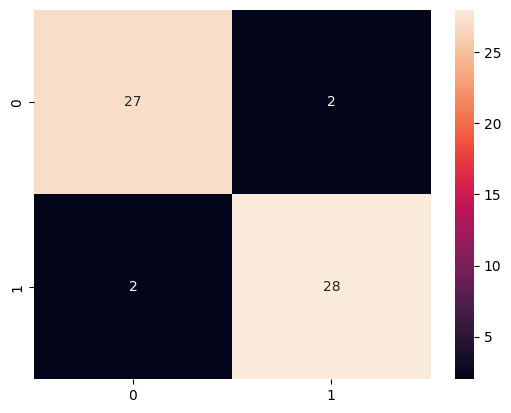

In [36]:
cm = confusion_matrix(y_test, clf_lr.predict(X_test))
sns.heatmap(cm, annot=True)
plt.show()

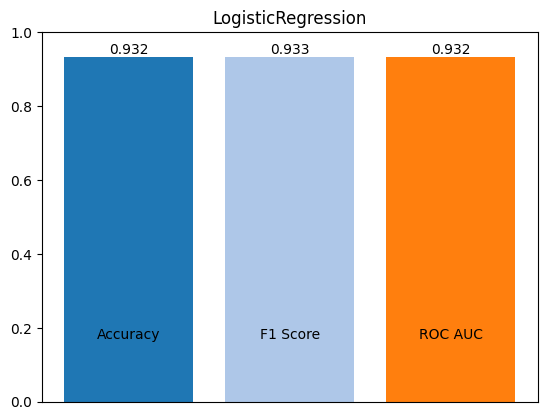

In [35]:
draw_scores(lr_scores, title="LogisticRegression")

## Decision Tree Classifier

In [37]:
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

y_dt_pred = clf_dt.predict(X_test)

dt_scores = score_method(y_test, y_dt_pred)

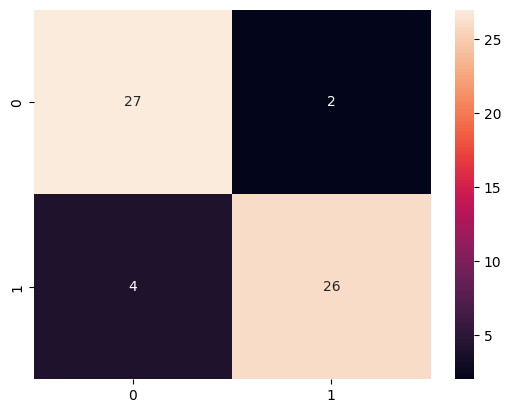

In [38]:
cm = confusion_matrix(y_test, y_dt_pred)
sns.heatmap(cm, annot=True)
plt.show()

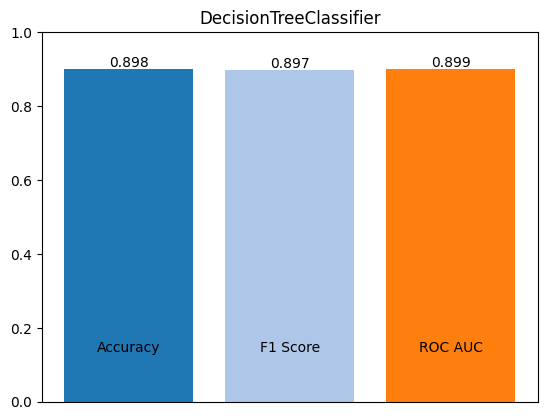

In [39]:
draw_scores(dt_scores, title="DecisionTreeClassifier")

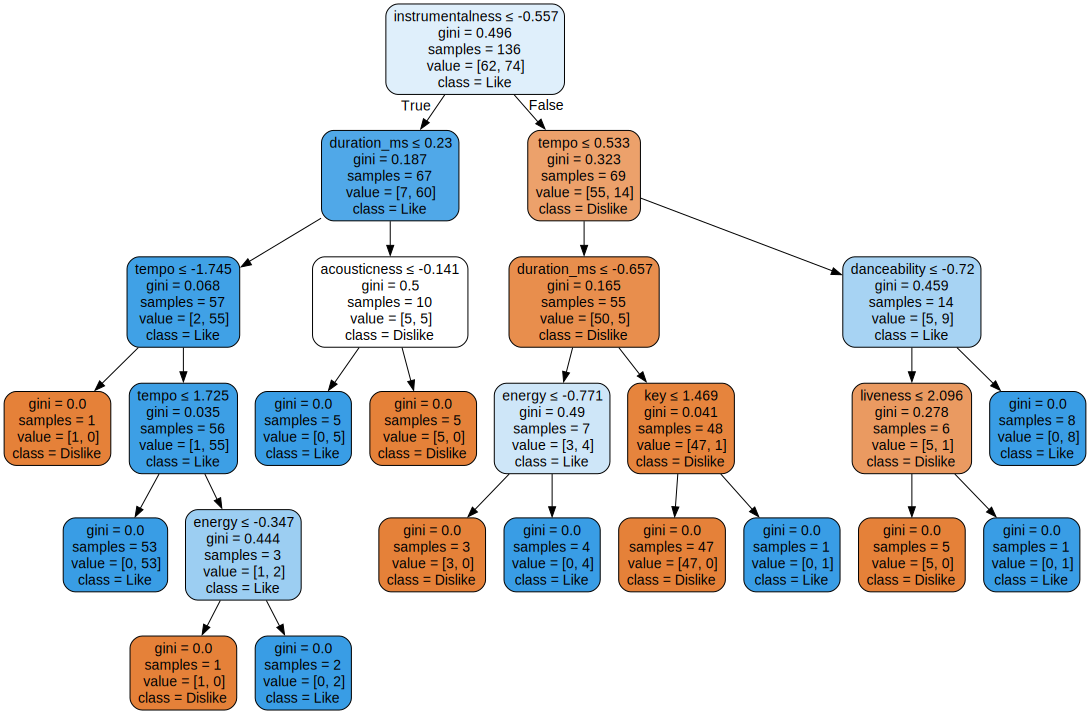

In [25]:
dot_data = tree.export_graphviz(clf_dt, out_file=None)
graph = graphviz.Source(dot_data)
graph.render('Liked')
dot_data = tree.export_graphviz(clf_dt, out_file=None,
                                feature_names=list(X_data.columns),
                                class_names=['Dislike', 'Like'],
                                filled=True, rounded=True,
                                special_characters=True)
graph = graphviz.Source(dot_data, format='png')
graph

## XGBoost

In [43]:
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)

y_xgb_pred = clf_xgb.predict(X_test)
xgb_scores = score_method(y_test, y_xgb_pred)

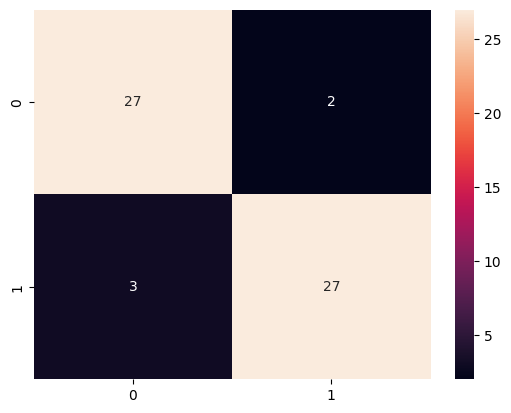

In [46]:
cm = confusion_matrix(y_test, y_xgb_pred)
sns.heatmap(cm, annot=True)
plt.show()

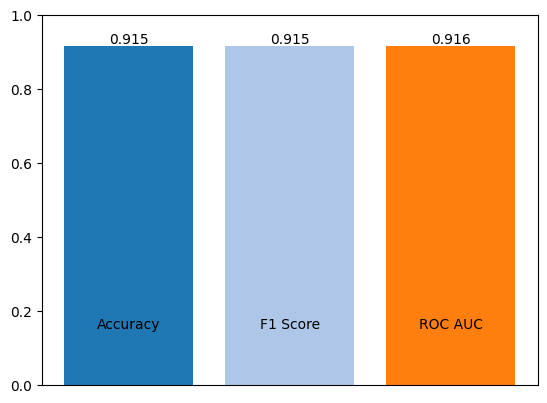

In [42]:
draw_scores(xgb_scores)

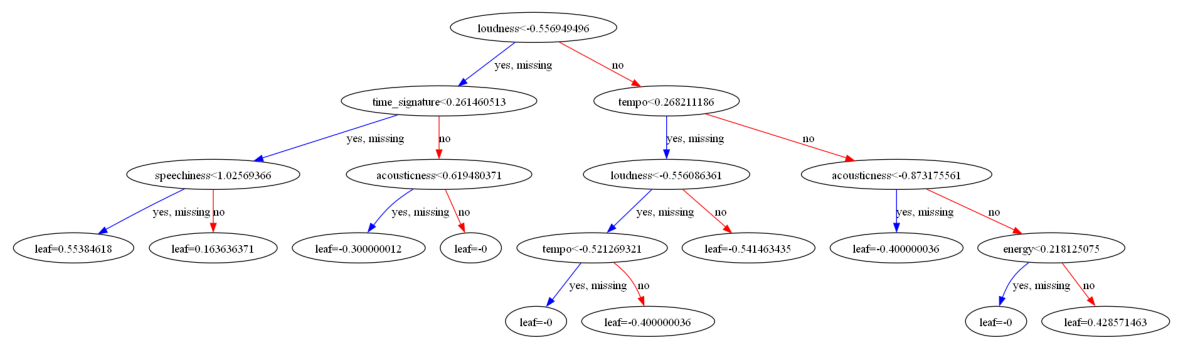

In [47]:
plot_tree(clf_xgb, num_trees=0, fmap="./data/feature_map.txt")
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.show()